In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score

# --- MODEL IMPORTS ---
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC, SVR

from xgboost import XGBClassifier, XGBRegressor
df = sns.load_dataset('diamonds')

In [2]:
print(df.head())
print("-------------------------")

print(df.info)
print("-------------------------")
print(df.describe())

   carat      cut color clarity  depth  table  price     x     y     z
0   0.23    Ideal     E     SI2   61.5   55.0    326  3.95  3.98  2.43
1   0.21  Premium     E     SI1   59.8   61.0    326  3.89  3.84  2.31
2   0.23     Good     E     VS1   56.9   65.0    327  4.05  4.07  2.31
3   0.29  Premium     I     VS2   62.4   58.0    334  4.20  4.23  2.63
4   0.31     Good     J     SI2   63.3   58.0    335  4.34  4.35  2.75
-------------------------
<bound method DataFrame.info of        carat        cut color clarity  depth  table  price     x     y     z
0       0.23      Ideal     E     SI2   61.5   55.0    326  3.95  3.98  2.43
1       0.21    Premium     E     SI1   59.8   61.0    326  3.89  3.84  2.31
2       0.23       Good     E     VS1   56.9   65.0    327  4.05  4.07  2.31
3       0.29    Premium     I     VS2   62.4   58.0    334  4.20  4.23  2.63
4       0.31       Good     J     SI2   63.3   58.0    335  4.34  4.35  2.75
...      ...        ...   ...     ...    ...    ...   

(53940, 10)


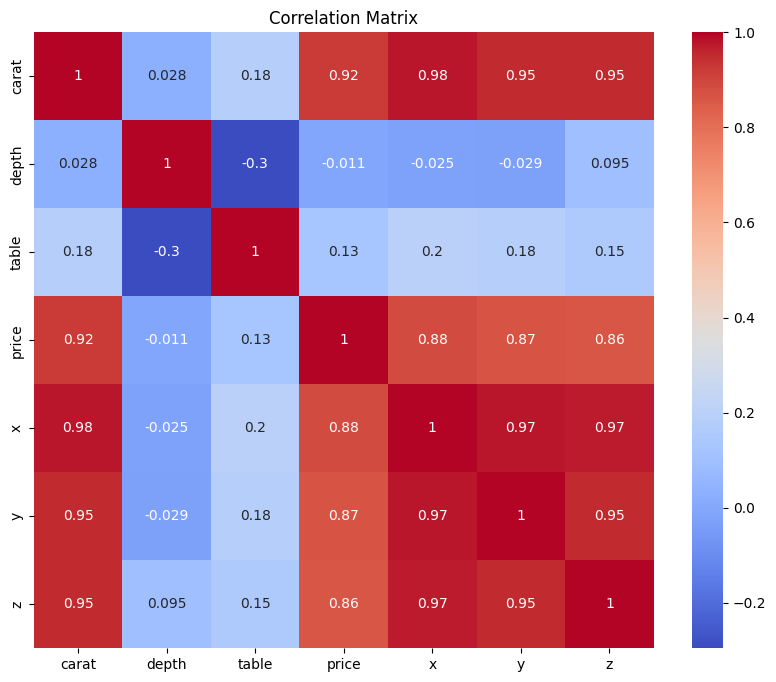

In [3]:
print(df.shape)
num_cols = df.select_dtypes(include = 'number')
plt.figure(figsize=(10,8))
sns.heatmap(df.select_dtypes(include='number').corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [4]:
# 1. Define the Dictionaries (The "Ranking")
# Cut: Fair is worst (1), Ideal is best (5)
cut_map = {'Fair': 1, 'Good': 2, 'Very Good': 3, 'Premium': 4, 'Ideal': 5}

# Color: J is worst (1), D is best (7)
color_map = {'J': 1, 'I': 2, 'H': 3, 'G': 4, 'F': 5, 'E': 6, 'D': 7}

# Clarity: I1 is worst (1), IF is best (8)
clarity_map = {'I1': 1, 'SI2': 2, 'SI1': 3, 'VS2': 4, 'VS1': 5, 'VVS2': 6, 'VVS1': 7, 'IF': 8}

# 2. Apply the Mapping
df['cut'] = df['cut'].map(cut_map)
df['color'] = df['color'].map(color_map)
df['clarity'] = df['clarity'].map(clarity_map)

# 3. VERIFY: Check if any text remains
print(df[['cut', 'color', 'clarity']].head())
# You should see numbers (5, 6, 2...), not text!

  cut color clarity
0   5     6       2
1   4     6       3
2   2     6       5
3   4     2       4
4   2     1       2


In [6]:
X = df.drop('price' , axis = 1)
y = df['price']

X_train, X_test,y_train, y_test = train_test_split(X,y, test_size=0.2 , random_state= 42)

num_cols = X.columns 


preproc = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Define the Model Pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preproc), # Just one step now
    ('model', XGBRegressor(random_state=42, n_jobs=-1))
])

param_grid = {
    'model__n_estimators': [500, 1000], 
    'model__learning_rate': [0.01, 0.05],
    'model__max_depth': [5, 7]
}

grid_search = GridSearchCV(model_pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

,estimator,"Pipeline(step...=None, ...))])"
,param_grid,"{'model__learning_rate': [0.01, 0.05], 'model__max_depth': [5, 7], 'model__n_estimators': [500, 1000]}"
,scoring,'r2'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,steps,"[('imputer', ...), ('scaler', ...)]"


In [7]:
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Training Score: {grid_search.best_score_:.4f}")
y_pred = grid_search.predict(X_test)
final_score = r2_score(y_test, y_pred)

print(f"Final Test R2 Score: {final_score:.4f}")

Best Parameters: {'model__learning_rate': 0.01, 'model__max_depth': 7, 'model__n_estimators': 1000}
Best Training Score: 0.9820
Final Test R2 Score: 0.9827
